# Example on MNIST

This example illustrates how ZerO works and avoids the training degeneracy (described by Thereom 1 in the paper).

Link of the paper: https://arxiv.org/abs/2110.12661

## Setup

In [ ]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import numpy as np
import math
from scipy.linalg import hadamard
import matplotlib.pyplot as plt
import torch.quantization
from torch.quantization import QuantStub, DeQuantStub


### Model
We consider a 4-layer multi-layer perceptron (MLP) where the hidden dimension is fixed. The models based on **random, partial identity, and ZerO** initialization are defined as follows:

In [ ]:
def ZerO_Init_on_matrix(matrix_tensor):
    # Algorithm 1 in the paper.

    m = matrix_tensor.size(0)
    n = matrix_tensor.size(1)

    if m <= n:
        init_matrix = torch.nn.init.eye_(torch.empty(m, n))
    elif m > n:
        clog_m = math.ceil(math.log2(m))
        p = 2**(clog_m)
        init_matrix = torch.nn.init.eye_(torch.empty(m, p)) @ (torch.tensor(hadamard(p)).float()/(2**(clog_m/2))) @ torch.nn.init.eye_(torch.empty(p, n))

    return init_matrix

def Identity_Init_on_matrix(matrix_tensor):
    # Definition 1 in the paper
    # See https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.eye_ for details. Preserves the identity of the inputs in Linear layers, where as many inputs are preserved as possible, the same as partial identity matrix.

    m = matrix_tensor.size(0)
    n = matrix_tensor.size(1)

    init_matrix = torch.nn.init.eye_(torch.empty(m, n))

    return init_matrix

In [ ]:
class MLP(nn.Module):
    '''
    a standard model with 4 hidden layers
    '''
    def __init__(self, n_h=1024, init='ZerO'):
        super(MLP, self).__init__()
        self.init = init
        self.n_h = n_h
        self.l1 = nn.Linear(784, 784, bias=False)
        self.l2 = nn.Linear(784, self.n_h, bias=False)
        self.l3 = nn.Linear(self.n_h, self.n_h, bias=False)
        self.l4 = nn.Linear(self.n_h, 10, bias=False)

        self.apply(self._init_weights)

    def forward(self, x):

        x = x.view(-1, 28 * 28)
        x = self.l1(x)
        x = F.relu(x)
        x = self.l2(x)
        x = F.relu(x)
        x = self.l3(x)
        x = F.relu(x)
        x = self.l4(x)

        return F.log_softmax(x)

    def _init_weights(self, m):

        if self.init == 'ZerO':
            if isinstance(m, nn.Linear):
                m.weight.data = ZerO_Init_on_matrix(m.weight.data)

        elif self.init == 'Partial_Identity':
            if isinstance(m, nn.Linear):
                m.weight.data = Identity_Init_on_matrix(m.weight.data)

        elif self.init == 'Random':
            if isinstance(m, nn.Linear):
                torch.nn.init.kaiming_normal_(m.weight)

        if isinstance(m, nn.Linear) and m.bias is not None:
            nn.init.constant_(m.bias, 0)

### Measurements

In [ ]:
def compute_rank(tensor):

    tensor = tensor.detach().cpu()
    rank = np.linalg.matrix_rank(tensor, tol=0.0001)

    return rank




### **FP8 Quantizer Function**

In [ ]:
temp_tensor=torch.randn(1024)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
temp_tensor=temp_tensor.to(device)
print(temp_tensor)
quant2=Quantizer(4,3)
quant_temp_tensor=quant2(temp_tensor)
print(quant_temp_tensor)

### Training Pipeline on MNIST

from https://github.com/pytorch/examples/blob/main/mnist/main.py

In [ ]:
class Optimizer(torch.optim.SGD):
    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue

                d_p = p.grad.data
                p.data.add_(d_p, alpha=-group['lr'])

        return loss

def train(args, model, device, train_loader, optimizer, epoch, train_acc_list, train_loss_list, rank_list_dict):
    model.train()
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAccuracy({:.0f}%)'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(),
                100. * correct / len(train_loader.dataset)))

            # log metric
            train_acc_list.append(100. * correct / len(train_loader.dataset))
            train_loss_list.append(loss.item())
            for name, param in model.named_parameters():
                if param.grad is not None:
                    if 'l3' in name:
                        if name not in rank_list_dict:
                            rank_list_dict[name] = []

                        # compute stable rank of the residual component
                        print(param.data)
                        rank_list_dict[name].append(compute_rank(param.data - torch.eye(param.data.size(0)).to(param.data.device)))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    return 100. * correct / len(test_loader.dataset)


def train_model(model, file_dir=None):
    # Training settings
    parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
    parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                        help='input batch size for training (default: 64)')
    parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                        help='input batch size for testing (default: 1000)')
    parser.add_argument('--epochs', type=int, default=2, metavar='N',
                        help='number of epochs to train (default: 14)')
    parser.add_argument('--lr', type=float, default=0.1, metavar='LR',
                        help='learning rate (default: 1.0)')
    parser.add_argument('--gamma', type=float, default=0.7, metavar='M',
                        help='Learning rate step gamma (default: 0.7)')
    parser.add_argument('--no-cuda', action='store_true', default=False,
                        help='disables CUDA training')
    parser.add_argument('--seed', type=int, default=1, metavar='S',
                        help='random seed (default: 1)')
    parser.add_argument('--log-interval', type=int, default=50, metavar='N',
                        help='how many batches to wait before logging training status')

    parser.add_argument('--save-model', action='store_true', default=False,
                        help='For Saving the current Model')

    parser.add_argument('--name', type=str, default='test')

    parser.add_argument('--init', type=str, default='ZerO')

    args = parser.parse_args([])
    use_cuda = not args.no_cuda and torch.cuda.is_available()

    torch.manual_seed(args.seed)

    device = torch.device("cuda" if use_cuda else "cpu")

    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                       ])),
        batch_size=args.batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                       ])),
        batch_size=args.test_batch_size, shuffle=True, **kwargs)

    model = model.to(device)
    # debug
    for name, params in model.named_parameters():
        print(name, params.data)
    optimizer = Optimizer(model.parameters(), lr=args.lr)

    # logging metric
    train_acc_list = []
    train_loss_list = []
    rank_list_dict = {}

    scheduler = StepLR(optimizer, step_size=12, gamma=args.gamma)

    for epoch in range(1, args.epochs + 1):
        train(args, model, device, train_loader, optimizer, epoch, train_acc_list, train_loss_list, rank_list_dict)
        test(model, device, test_loader)
        scheduler.step()

    if args.save_model:
        torch.save(model.state_dict(), args.init + "_mnist_cnn.pt")

    return rank_list_dict,model

## Verification of Theorem 1 (Figure 3 in the paper)

### Figure 3 (left): identity initialization under different widths

We show that the rank constraints (training degeneracy) happen no matter what the width is. The ranks are always smaller than the input dimension (784=28 * 28).

In [ ]:
import copy
FP8_quant_MLP = copy.deepcopy(MLP)

In [ ]:
# n_h_256_rank_list_dict = train_model(MLP(init='Partial_Identity', n_h=256))

# n_h_512_rank_list_dict = train_model(MLP(init='Partial_Identity', n_h=512))

# n_h_1024_rank_list_dict = train_model(MLP(init='Partial_Identity', n_h=1024))

# n_h_2048_rank_list_dict = train_model(MLP(init='Partial_Identity', n_h=2048))

# plotting
# import numpy as np
# import matplotlib.pyplot as plt

# fig, ax = plt.subplots(1,1, figsize=(5,4), gridspec_kw = {'wspace':0.5, 'hspace':0.5})

# x_axis = np.arange(1, len(n_h_512_rank_list_dict['l3.weight'])+1)
# x_axis = x_axis * 50

# # generate a line of 784
# input_dim_line = np.ones(len(n_h_512_rank_list_dict['l3.weight'])) * 784

# ax.plot(x_axis, input_dim_line, label='input_dim=784', linestyle='dashed', color='red', linewidth='2')
# ax.plot(x_axis, n_h_256_rank_list_dict['l3.weight'], label='n_h=256', linewidth='2')
# ax.plot(x_axis, n_h_512_rank_list_dict['l3.weight'], label='n_h=512', linewidth='2')
# ax.plot(x_axis, n_h_1024_rank_list_dict['l3.weight'], label='n_h=1024', linewidth='2')
# ax.plot(x_axis, n_h_2048_rank_list_dict['l3.weight'], label='n_h=2048', linewidth='2')

# ax.set_ylabel('Rank', fontsize=14)
# ax.set_xlabel('Iterations', fontsize=14)
# ax.legend(fontsize=12)

# fig.tight_layout(w_pad=0.5)
# plt.show()
# fig.savefig('./figure_3_left.pdf', bbox_inches='tight')

### Figure 3 (right): Hadamard transfrom breaks training degeneracy

We show that when initializing dimension-increasing layer with Hadamard transform, the rank constraints (training degeneracy) not exsist any more. The rank can be greater than the input dimension during training.

In [ ]:
class Quantizer(nn.Module):
    def __init__(self, m, e,gamma):
        super().__init__()
        self.m = m # number of mantissa bit
        self.e = e # number of exponent bit
        self.gamma=gamma
    def forward(self, input):
        sign=torch.sign(input) #sign bit
        b= 2**(self.e-1) #bias
        device='cuda' if torch.cuda.is_available() else 'cpu'
        b=b-torch.log2(torch.tensor(self.gamma))
        b=b.to(device)
        c=(2-2**(-self.m))*2**(2**self.e-b-1)  #maximum representable range i.e. dynamic range
        # p= torch.floor(torch.log2(abs(input)))-self.m
        temp=torch.floor(torch.log2(abs(input))+b)
        temp_max=temp.max()
        temp_max=temp_max.to(device)
        temp_min=torch.tensor(1)
        temp_min=temp_min.to(device)
        if temp_max<temp_min:
          temp_max=temp_min
        temp=torch.clamp(temp,temp_min,temp_max)
        # if torch.floor(torch.log2(abs(input))+b)>1:
        #  p=torch.floor(torch.log2(abs(input))+b)-b-torch.round(self.m)
        # else :
        #  p=1-b-torch.round(self.m)
        p=temp-b-torch.round(torch.tensor(self.m))
        # p_min=torch.tensor(1-b-self.m)
        # device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # p_min=p_min.to(device)
        # p_max=p.max()
        # p_max=p_max.to(device)
        # if p_max<p_min:
          # p_max=p_min
        # p=torch.clamp(p,p_min,p_max)
        s=2**p
        output = torch.clamp(sign*s*torch.round(abs(input)/s),-c,c)
        # output=input

        return output

class QuantizedMLP(nn.Module):
    def __init__(self, model):
        super(QuantizedMLP, self).__init__()
        # QuantStub converts tensors from floating point to quantized.
        # This will only be used for inputs.
        self.quant = Quantizer(4,3,1)
        # DeQuantStub converts tensors from quantized to floating point.
        # This will only be used for outputs.
        # self.dequant = torch.quantization.DeQuantStub()
        # FP32 model
        self.model = model
        # device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # self.l1_init_weight=model.l1.weight.data
        # self.l1_init_weight=self.l1_init_weight.to(device)
        # self.l2_init_weight=model.l2.weight.data
        # self.l2_init_weight=self.l2_init_weight.to(device)
        # self.l3_init_weight=model.l3.weight.data
        # self.l3_init_weight=self.l3_init_weight.to(device)
        # self.l4_init_weight=model.l4.weight.data
        # self.l4_init_weight=self.l4_init_weight.to(device)
        # print(self.l1_init_weight)
    def forward(self, x):
        # manually specify where tensors will be converted from floating
        # point to quantized in the quantized model
        x=x.view(-1,28*28)
        x=self.quant(x)
        # W=self.model.l1.weight.data
        # self.model.l1.weight.data=self.l1_init_weight+self.quant(W-self.l1_init_weight)
        # self.model.l1.weight.data=self.quant(W)
        x=self.model.l1(x)
        # x=self.quant(x)
        x=F.relu(x)
        # x=self.quant(x)
        # W=self.model.l2.weight.data
        # self.model.l2.weight.data=self.l2_init_weight+self.quant(W-self.l2_init_weight)
        # self.model.l2.weight.data=self.quant(W)
        x=self.model.l2(x)
        # x=self.quant(x)
        x=F.relu(x)
        # x=self.quant(x)
        # W=self.model.l3.weight.data
        # self.model.l3.weight.data=self.l3_init_weight+self.quant(W-self.l3_init_weight)
        # self.model.l3.weight.data=self.quant(W)
        x=self.model.l3(x)
        # x=self.quant(x)
        x=F.relu(x)
        # x=self.quant(x)
        # W=self.model.l4.weight.data
        # self.model.l4.weight.data=self.l4_init_weight+self.quant(W-self.l4_init_weight)
        # self.model.l4.weight.data=self.quant(W)
        x=self.model.l4(x)
        # x=self.quant(x)
        # x = self.model(x)
        # x = self.quant(x)
        # manually specify where tensors will be converted from quantized
        # to floating point in the quantized model
        # x = self.dequant(x)
        # x=F.log_softmax(x)
        # x=self.quant(x)
        return F.log_softmax(x)
        # return x

In [ ]:
# print('model_rand')
# random_init_rank_list_dict,model_rand = train_model(MLP(init='Random', n_h=2048))
print('model_rand_quant')
random_init_rank_list_dict_FP8_quant,model_rand_quant = train_model(QuantizedMLP(FP8_quant_MLP(init='Random', n_h=2048)))
# print('model_partial')
# partial_identity_init_rank_list_dict,model_partial = train_model(MLP(init='Partial_Identity', n_h=2048))
# print('model_partial_quant')
# partial_identity_init_rank_list_dict_FP8_quant,model_partial_FP8_quant = train_model(QuantizedMLP(FP8_quant_MLP(init='Partial_Identity', n_h=2048)))
# print('model_ZerO')
# ZerO_init_rank_list_dict,model_ZerO = train_model(MLP(init='ZerO', n_h=2048))
print('model_ZerO_quant')
ZerO_init_rank_list_dict_FP8_quant,model_ZerO_FP8_quant = train_model(QuantizedMLP(FP8_quant_MLP(init='ZerO', n_h=2048)))



model_rand_quant
model.l1.weight tensor([[-2.7448e-02, -3.2748e-02,  2.3963e-02,  ..., -1.7463e-02,
         -3.3231e-02, -2.4177e-02],
        [-1.3858e-02, -5.1563e-02,  6.0303e-02,  ...,  7.6206e-02,
         -1.6132e-02, -2.4891e-02],
        [ 4.3044e-02,  7.7571e-02, -1.4022e-02,  ...,  4.1556e-02,
         -6.9273e-02,  2.3381e-05],
        ...,
        [-3.1329e-02, -3.6133e-02, -1.6154e-02,  ..., -5.3324e-03,
         -5.0084e-02,  3.6675e-02],
        [ 4.1213e-02,  6.0945e-02,  1.3815e-02,  ...,  3.1495e-02,
         -1.2127e-02, -3.3966e-02],
        [ 3.3884e-02, -3.7613e-03, -1.1464e-01,  ..., -2.1665e-02,
         -6.2421e-02, -6.3243e-02]], device='cuda:0')
model.l2.weight tensor([[ 0.0425, -0.0548, -0.0692,  ..., -0.0220,  0.0378,  0.0619],
        [-0.0586,  0.0157,  0.0197,  ..., -0.0205,  0.0455, -0.0078],
        [ 0.0145, -0.0108,  0.0769,  ..., -0.0172,  0.0232,  0.0170],
        ...,
        [ 0.0584,  0.0537, -0.0550,  ...,  0.0871,  0.0258, -0.0399],
        [

<ipython-input-10-99ae8562d033>:101: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.680358	Accuracy(3%)
tensor([[ 0.0025, -0.0036,  0.0317,  ...,  0.0064, -0.0008, -0.0027],
        [-0.0027,  0.0277, -0.0129,  ..., -0.0101, -0.0130,  0.0028],
        [-0.0350,  0.0511, -0.0196,  ...,  0.0621,  0.0331, -0.0299],
        ...,
        [ 0.0262, -0.0151, -0.0642,  ..., -0.0089, -0.0280,  0.0177],
        [ 0.0229,  0.0326, -0.0656,  ..., -0.0003, -0.0188,  0.0080],
        [ 0.0618, -0.0456,  0.0363,  ..., -0.0367,  0.0155, -0.0160]],
       device='cuda:0')
Train Epoch: 1 [6400/60000 (11%)]	Loss: nan	Accuracy(5%)
tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], device='cuda:0')


LinAlgError: ignored

Quantization of only activations
applying quantization after relu
random init = 93
ZerO init = 92

NameError: ignored

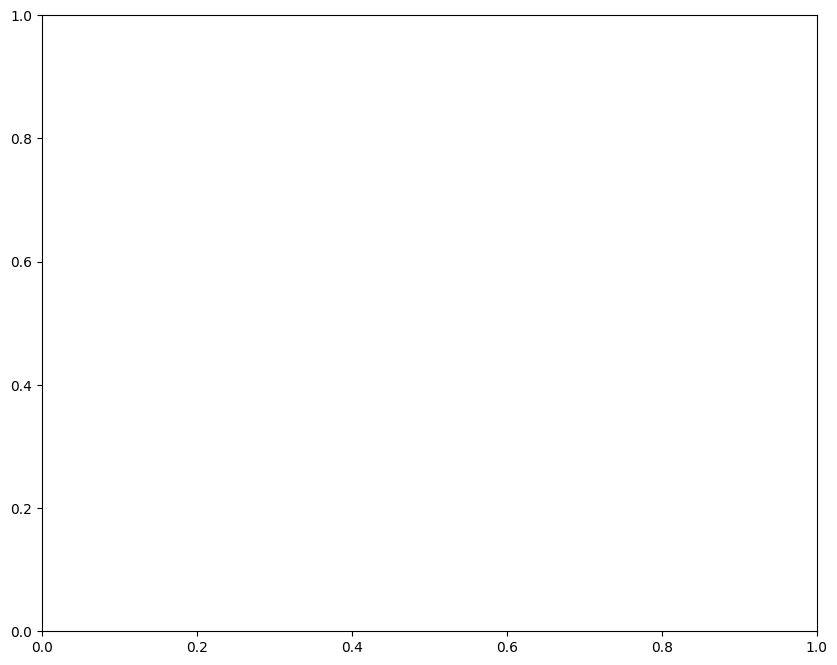

In [ ]:
xfig, ax = plt.subplots(1,1, figsize=(10,8), gridspec_kw = {'wspace':0.5, 'hspace':0.5})

x_axis = np.arange(1, len(random_init_rank_list_dict['l3.weight'])+1)
x_axis = x_axis * 50

# generate a line of 784
input_dim_line = np.ones(len(random_init_rank_list_dict['l3.weight'])) * 784

ax.plot(x_axis, input_dim_line, label='input_dim=784', linestyle='dashed', color='red', linewidth='2')
ax.plot(x_axis, random_init_rank_list_dict['l3.weight'], label='Random Init', linewidth='2')
ax.plot(x_axis, random_init_rank_list_dict_FP8_quant['model.l3.weight'], label='Random Init FP8 quant', linewidth='2')
ax.plot(x_axis, partial_identity_init_rank_list_dict['l3.weight'], label='Partial Identity Init', linewidth='2')
ax.plot(x_axis, partial_identity_init_rank_list_dict_FP8_quant['model.l3.weight'], label='Partial Identity Init FP8 quant', linewidth='2')
ax.plot(x_axis, ZerO_init_rank_list_dict['l3.weight'], label='ZerO Init ', linewidth='2')
ax.plot(x_axis, ZerO_init_rank_list_dict_FP8_quant['model.l3.weight'], label='ZerO Init FP8 quant', linewidth='2')


ax.set_ylabel('Rank', fontsize=14)

ax.set_xlabel('Iterations', fontsize=14)
ax.legend(fontsize=10)

fig.tight_layout(w_pad=0.5)
plt.show()
fig.savefig('./figure_3_right.pdf', bbox_inches='tight')


# **INT8 quantization**

## **Quantization Function**

In [ ]:
from collections import namedtuple
QTensor = namedtuple('QTensor', ['tensor', 'scale', 'zero_point'])

def calcScaleZeroPoint(min_val, max_val,num_bits=8):
  # Calc Scale and zero point of next
  qmin = 0.
  qmax = 2.**num_bits - 1.

  scale = (max_val - min_val) / (qmax - qmin)

  initial_zero_point = qmin - min_val / scale

  zero_point = 0
  if initial_zero_point < qmin:
      zero_point = qmin
  elif initial_zero_point > qmax:
      zero_point = qmax
  else:
      zero_point = initial_zero_point

  zero_point = int(zero_point)

  return scale, zero_point

def quantize_tensor(x, num_bits=8, min_val=None, max_val=None):

    if not min_val and not max_val:
      min_val, max_val = x.min(), x.max()

    qmin = 0.
    qmax = 2.**num_bits - 1.

    scale, zero_point = calcScaleZeroPoint(min_val, max_val, num_bits)
    q_x = zero_point + x / scale
    q_x.clamp_(qmin, qmax).round_()
    q_x = q_x.round().byte()

    return QTensor(tensor=q_x, scale=scale, zero_point=zero_point)

def dequantize_tensor(q_x):
    return q_x.scale * (q_x.tensor.float() - q_x.zero_point)

In [ ]:
def quantizeLayer(x, layer, stat, scale_x, zp_x):
  # for both conv and linear layers

  # cache old values
  W = layer.weight.data
  # B = layer.bias.data

  # quantise weights, activations are already quantised
  w = quantize_tensor(layer.weight.data)
  # b = quantize_tensor(layer.bias.data)

  layer.weight.data = w.tensor.float()
  # layer.bias.data = b.tensor.float()

  # This is Quantisation Artihmetic
  scale_w = w.scale
  zp_w = w.zero_point
  # scale_b = b.scale
  # zp_b = b.zero_point

  scale_next, zero_point_next = calcScaleZeroPoint(min_val=stat['min'], max_val=stat['max'])

  # Preparing input by shifting
  X = x.float() - zp_x
  layer.weight.data = scale_x * scale_w*(layer.weight.data - zp_w)
  # layer.bias.data = scale_b*(layer.bias.data + zp_b)

  # All int computation
  x = (layer(X)/ scale_next) + zero_point_next

  # Perform relu too
  x = F.relu(x)

  # Reset weights for next forward pass
  layer.weight.data = W
  # layer.bias.data = B

  return x, scale_next, zero_point_next



In [ ]:
# Get Min and max of x tensor, and stores it
def updateStats(x, stats, key):
  max_val, _ = torch.max(x, dim=1)
  min_val, _ = torch.min(x, dim=1)


  if key not in stats:
    stats[key] = {"max": max_val.sum(), "min": min_val.sum(), "total": 1}
  else:
    stats[key]['max'] += max_val.sum().item()
    stats[key]['min'] += min_val.sum().item()
    stats[key]['total'] += 1

  return stats

# Reworked Forward Pass to access activation Stats through updateStats function
def gatherActivationStats(model, x, stats):

  x = x.view(-1, 28*28)

  stats = updateStats(x, stats, 'l1')

  x = F.relu(model.l1(x))

  stats = updateStats(x, stats, 'l2')

  x = F.relu(model.l2(x))

  stats = updateStats(x, stats, 'l3')

  x = F.relu(model.l3(x))

  stats = updateStats(x, stats, 'l4')

  x = model.l4(x)

  return stats

# Entry function to get stats of all functions.
def gatherStats(model, test_loader):
    device = 'cuda'

    model.eval()
    test_loss = 0
    correct = 0
    stats = {}
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            stats = gatherActivationStats(model, data, stats)

    final_stats = {}
    for key, value in stats.items():
      final_stats[key] = { "max" : value["max"] / value["total"], "min" : value["min"] / value["total"] }
    return final_stats

In [ ]:
def quantForward(model, x, stats):

  # Quantise before inputting into incoming layers
  x = x.view(-1, 28*28)

  x = quantize_tensor(x, min_val=stats['l1']['min'], max_val=stats['l1']['max'])

  x, scale_next, zero_point_next = quantizeLayer(x.tensor, model.l1, stats['l2'], x.scale, x.zero_point)

  x, scale_next, zero_point_next = quantizeLayer(x, model.l2, stats['l3'], scale_next, zero_point_next)

  x, scale_next, zero_point_next = quantizeLayer(x, model.l3, stats['l4'], scale_next, zero_point_next)

  # Back to dequant for final layer
  x = dequantize_tensor(QTensor(tensor=x, scale=scale_next, zero_point=zero_point_next))

  x = model.l4(x)

  return F.log_softmax(x,dim=1)

In [ ]:
def testQuant(model, test_loader, quant=False, stats=None):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            if quant:
              output = quantForward(model, data, stats)
            else:
              output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [ ]:
INT8_quant_MLP = copy.deepcopy(model_ZerO)

In [ ]:
kwargs = {'num_workers': 1, 'pin_memory': True}
train_loader = torch.utils.data.DataLoader(
      datasets.MNIST('../data', train=True, download=True,
                      transform=transforms.Compose([
                          transforms.ToTensor(),
                      ])),
      batch_size=1000, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                       ])),
        batch_size=1000, shuffle=True, **kwargs)

In [ ]:
testQuant(INT8_quant_MLP, test_loader, quant=False)

<ipython-input-3-1ba25c7416bf>:27: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set: Average loss: 0.0990, Accuracy: 9700/10000 (97%)



In [ ]:
stats = gatherStats(INT8_quant_MLP, test_loader)
print(stats)


{'l1': {'max': tensor(999.5996, device='cuda:0'), 'min': tensor(0., device='cuda:0')}, 'l2': {'max': tensor(1607.0243, device='cuda:0'), 'min': tensor(0., device='cuda:0')}, 'l3': {'max': tensor(3174.3877, device='cuda:0'), 'min': tensor(0., device='cuda:0')}, 'l4': {'max': tensor(5651.7241, device='cuda:0'), 'min': tensor(0., device='cuda:0')}}


In [ ]:
testQuant(INT8_quant_MLP, test_loader, quant=True, stats=stats)


Test set: Average loss: 2.3026, Accuracy: 980/10000 (10%)



# **Alternate method for INT8 quantization**

In [ ]:
class MLP2(nn.Module):
    '''
    a standard model with 4 hidden layers
    '''
    def __init__(self, n_h=1024, init='ZerO',q=False):
        super(MLP, self).__init__()
        self.init = init
        self.n_h = n_h
        self.l1 = nn.Linear(784, 784, bias=False)
        self.l2 = nn.Linear(784, self.n_h, bias=False)
        self.l3 = nn.Linear(self.n_h, self.n_h, bias=False)
        self.l4 = nn.Linear(self.n_h, 10, bias=False)

        self.apply(self._init_weights)

        self.q=q
        if q:
          self.qaunt=QuantStub()
          self.dequant=DeQuantStub()
    def forward(self, x):
        if self.q:
          x=self.quant(x)

        x = x.view(-1, 28 * 28)
        x = self.l1(x)
        x = F.relu(x)
        x = self.l2(x)
        x = F.relu(x)
        x = self.l3(x)
        x = F.relu(x)
        x = self.l4(x)

        if self.q:
          x=self.dequant(x)
        return F.log_softmax(x)

    def _init_weights(self, m):

        if self.init == 'ZerO':
            if isinstance(m, nn.Linear):
                m.weight.data = ZerO_Init_on_matrix(m.weight.data)

        elif self.init == 'Partial_Identity':
            if isinstance(m, nn.Linear):
                m.weight.data = Identity_Init_on_matrix(m.weight.data)

        elif self.init == 'Random':
            if isinstance(m, nn.Linear):
                torch.nn.init.kaiming_normal_(m.weight)

        if isinstance(m, nn.Linear) and m.bias is not None:
            nn.init.constant_(m.bias, 0)

NameError: ignored

In [ ]:
import os
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)

def accuracy(output, target):
    """ Computes the top 1 accuracy """
    with torch.no_grad():
        batch_size = target.size(0)

        _, pred = output.topk(1, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        correct_one = correct[:1].view(-1).float().sum(0, keepdim=True)
        return correct_one.mul_(100.0 / batch_size).item()

def print_size_of_model(model):
    """ Prints the real size of the model """
    torch.save(model.state_dict(), "temp.p")
    print('Size (MB):', os.path.getsize("temp.p")/1e6)
    os.remove('temp.p')

def load_model(quantized_model, model):
    """ Loads in the weights into an object meant for quantization """
    state_dict = model.state_dict()
    model = model.to('cpu')
    quantized_model.load_state_dict(state_dict)

def fuse_modules(model):
    """ Fuse together convolutions/linear layers and ReLU """
    torch.quantization.fuse_modules(model, [['l1'],
                                            ['l2'],
                                            ['l3'],
                                            ['l4']], inplace=True)

In [ ]:
net = MLP2(q=False).cuda()
print_size_of_model(net)